### Imports

In [1]:
# Data manipulation and analysis
import pandas as pd

# System utilities for path handling
import sys
import os

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import the Apriori tool
sys.path.append(os.path.abspath(os.path.join(os. path.dirname('__file__'), '../../')))
from modules.tool_apriori import run_apriori

### Load the Data

In [2]:
groceries = pd.read_csv('../../data/Groceries_dataset.csv')
groceries.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


### Preprocessing

##### Clean Column Names and Data Types

In [3]:
# Strip whitespace from column names
groceries.columns = groceries.columns.str.strip()

# Convert Date to datetime
groceries['Date'] = pd.to_datetime(groceries['Date'], format='%d-%m-%Y')

# Clean item descriptions
groceries['itemDescription'] = groceries['itemDescription']. str.strip()
groceries['itemDescription'] = groceries['itemDescription'].str.lower()

# Create Transaction_ID
groceries['Transaction_ID'] = groceries['Member_number'].astype(str) + '_' + groceries['Date'].astype(str)

print(f"Columns: {groceries.columns.tolist()}")
print(groceries.head())

Columns: ['Member_number', 'Date', 'itemDescription', 'Transaction_ID']
   Member_number       Date   itemDescription   Transaction_ID
0           1808 2015-07-21    tropical fruit  1808_2015-07-21
1           2552 2015-01-05        whole milk  2552_2015-01-05
2           2300 2015-09-19         pip fruit  2300_2015-09-19
3           1187 2015-12-12  other vegetables  1187_2015-12-12
4           3037 2015-02-01        whole milk  3037_2015-02-01


##### Remove Missing Values and Duplicates

In [4]:
# Check for missing values
print(f"Missing values before removal:")
print(groceries.isnull().sum())

# Remove missing values
groceries = groceries.dropna()

# Remove duplicate rows
groceries = groceries.drop_duplicates()

print(f"\nMissing values and duplicates removed!")
print(f"Dataset shape after cleaning: {groceries.shape}")
print(f"Total transactions: {groceries['Transaction_ID']. nunique():,}")
print(f"Unique products: {groceries['itemDescription'].nunique():,}")

Missing values before removal:
Member_number      0
Date               0
itemDescription    0
Transaction_ID     0
dtype: int64

Missing values and duplicates removed!
Dataset shape after cleaning: (38006, 4)
Total transactions: 14,963
Unique products: 167


#### Create Market Basket Matrix

In [5]:
# Create binary basket (transactions x products)
basket = groceries.groupby(['Transaction_ID', 'itemDescription']).size().unstack(fill_value=0)

print(f"Shape: {basket.shape} (Transactions × Products)")
print(f"\nFirst 5 transactions × first 5 products:")
print(basket.iloc[:5, :5])

Shape: (14963, 167) (Transactions × Products)

First 5 transactions × first 5 products:
itemDescription  abrasive cleaner  artif. sweetener  baby cosmetics  bags  \
Transaction_ID                                                              
1000_2014-06-24                 0                 0               0     0   
1000_2015-03-15                 0                 0               0     0   
1000_2015-05-27                 0                 0               0     0   
1000_2015-07-24                 0                 0               0     0   
1000_2015-11-25                 0                 0               0     0   

itemDescription  baking powder  
Transaction_ID                  
1000_2014-06-24              0  
1000_2015-03-15              0  
1000_2015-05-27              0  
1000_2015-07-24              0  
1000_2015-11-25              0  


##### Binary Encoding

In [6]:
# Convert quantities to binary (0 or 1)
basket_encoded = (basket > 0).astype(int)

print(f"Shape: {basket_encoded.shape}")
print(f"Percentage of 1s: {(basket_encoded == 1).sum().sum() / basket_encoded.size * 100:.2f}%")
print(f"\nFirst 5 transactions × first 5 products (Binary):")
print(basket_encoded.iloc[:5, :5])

Shape: (14963, 167)
Percentage of 1s: 1.52%

First 5 transactions × first 5 products (Binary):
itemDescription  abrasive cleaner  artif. sweetener  baby cosmetics  bags  \
Transaction_ID                                                              
1000_2014-06-24                 0                 0               0     0   
1000_2015-03-15                 0                 0               0     0   
1000_2015-05-27                 0                 0               0     0   
1000_2015-07-24                 0                 0               0     0   
1000_2015-11-25                 0                 0               0     0   

itemDescription  baking powder  
Transaction_ID                  
1000_2014-06-24              0  
1000_2015-03-15              0  
1000_2015-05-27              0  
1000_2015-07-24              0  
1000_2015-11-25              0  


##### Remove Rare Items

In [ ]:
# Calculate minimum support threshold (0.5%)
min_support_count = int(basket_encoded.shape[0] * 0.005)

# Get product frequency
product_support = (basket_encoded == 1).sum()

# Remove rare items
rare_items = product_support[product_support < min_support_count]
basket_encoded = basket_encoded. drop(columns=rare_items.index)

print(f"Items removed: {len(rare_items)}")
print(f"Final shape: {basket_encoded.shape}")
print(f"\nTop 10 most frequent items:")
print((basket_encoded == 1).sum().sort_values(ascending=False).head(10))

Items removed: 77
Final shape: (14963, 90)

Top 10 most frequent items:
itemDescription
whole milk          2363
other vegetables    1827
rolls/buns          1646
soda                1453
yogurt              1285
root vegetables     1041
tropical fruit      1014
bottled water        908
sausage              903
citrus fruit         795
dtype: int64


##### Calculate Statistics

In [ ]:
# Calculate analysis statistics
num_transactions = basket_encoded.shape[0]
num_products = basket_encoded.shape[1]
min_support = 0.005
min_transactions = int(num_transactions * min_support)

print(f"Analysis Statistics:")
print(f"{'='*50}")
print(f"Total Transactions: {num_transactions:,}")
print(f"Total Products: {num_products:,}")
print(f"Minimum Support Threshold: {min_support*100}%")
print(f"Minimum Transactions Required: {min_transactions}")
print(f"{'='*50}")

📊 Analysis Statistics:
Total Transactions: 14,963
Total Products: 90
Minimum Support Threshold: 0.5%
Minimum Transactions Required: 74


##### Run Apriori Algorithm

In [10]:
# Run the apriori algorithm
frequent_items, rules = run_apriori(
    basket_encoded, 
    min_support=0.005, 
    metric="lift", 
    min_threshold=1
)

print(f"Frequent itemsets found: {len(frequent_items)}")
print(f"Association rules found: {len(rules)}")

if not frequent_items.empty:
    print(f"\nTop 5 Frequent Items:")
    print(frequent_items.sort_values('support', ascending=False).head())

g:\The Last Year\Data Mining\Data-Mining-Project\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent itemsets found: 126
Association rules found: 6

Top 5 Frequent Items:
     support            itemsets
87  0.157923        (whole milk)
52  0.122101  (other vegetables)
65  0.110005        (rolls/buns)
74  0.097106              (soda)
88  0.085879            (yogurt)


##### Display Association Rules

In [11]:
if not rules.empty:
    print(f"Top 5 Association Rules:")
    print(f"{'='*80}")
    
    display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    
    for idx, row in rules.head(5).iterrows():
        antecedent = ', '.join(list(row['antecedents']))
        consequent = ', '.join(list(row['consequents']))
        print(f"\nRule {idx + 1}:")
        print(f"  If buy:  {antecedent}")
        print(f"  Then likely buy: {consequent}")
        print(f"  Confidence: {row['confidence']*100:.2f}%")
        print(f"  Lift: {row['lift']:.4f}x")
else:
    print(f"No association rules found")

Top 5 Association Rules:

Rule 2:
  If buy:  frankfurter
  Then likely buy: other vegetables
  Confidence: 13.63%
  Lift: 1.1161x

Rule 1:
  If buy:  other vegetables
  Then likely buy: frankfurter
  Confidence: 4.21%
  Lift: 1.1161x

Rule 6:
  If buy:  sausage
  Then likely buy: yogurt
  Confidence: 9.52%
  Lift: 1.1090x

Rule 5:
  If buy:  yogurt
  Then likely buy: sausage
  Confidence: 6.69%
  Lift: 1.1090x

Rule 4:
  If buy:  sausage
  Then likely buy: soda
  Confidence: 9.86%
  Lift: 1.0150x


##### Save Results

In [14]:
if not rules.empty:
    # Prepare data for export
    rules_export = rules.copy()
    rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))
    
    # Save to CSV
    output_filename = 'rules_results_Groceries.csv'
    rules_export.to_csv(output_filename, index=False)
    
    print(f"Results saved to:  {output_filename}")
    print(f"Total rules saved: {len(rules_export)}")
else:
    print(f"No results to save")

Results saved to:  rules_results_Groceries.csv
Total rules saved: 6


##### Create Visualization

Creating visualization...
Plot saved as: plot_Groceries.png


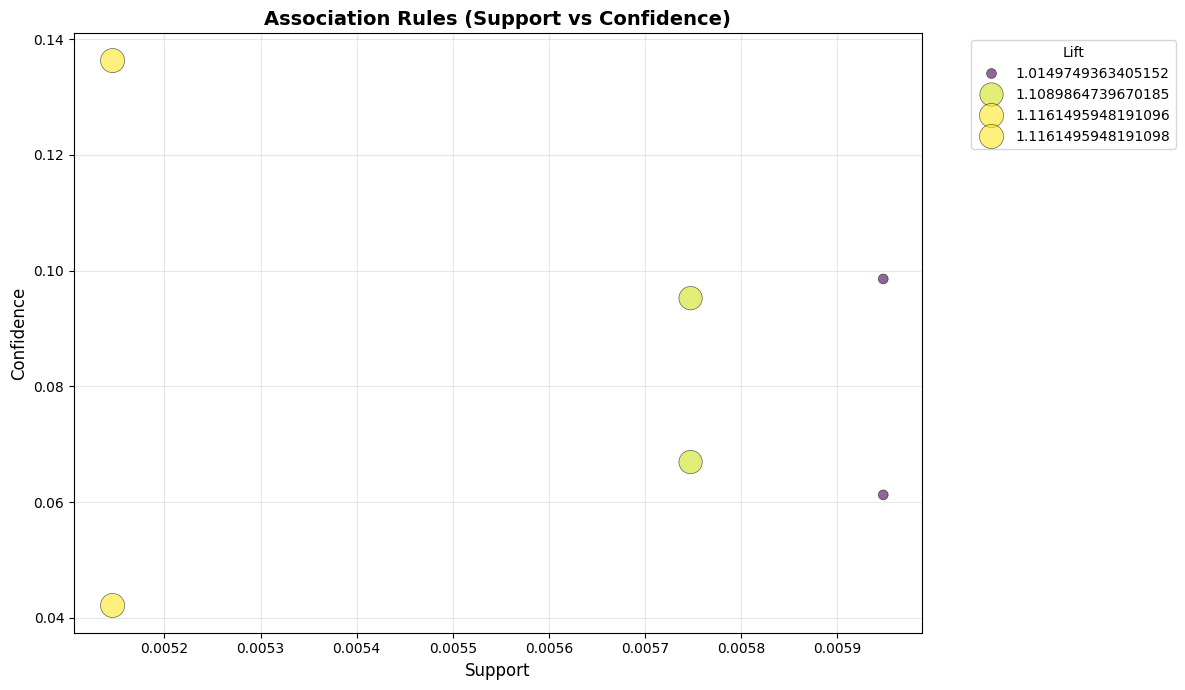

In [15]:
if not rules.empty:
    print(f"Creating visualization...")
    
    plt.figure(figsize=(12, 7))
    
    sns.scatterplot(
        data=rules, 
        x="support", 
        y="confidence", 
        size="lift", 
        hue="lift", 
        palette="viridis", 
        sizes=(50, 300),
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )
    
    plt.title(f"Association Rules (Support vs Confidence)", fontsize=14, fontweight='bold')
    plt.xlabel("Support", fontsize=12)
    plt.ylabel("Confidence", fontsize=12)
    plt.legend(title="Lift", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    plot_filename = 'plot_Groceries.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved as: {plot_filename}")
    
    plt.show()
else:
    print(f"No rules to visualize")

##### Summary

In [16]:
print(f"\n{'='*70}")
print(f"Analysis Complete!")
print(f"{'='*70}")

print(f"\nGenerated Files:")
print(f"  1. rules_results_Groceries.csv")
print(f"  2. plot_Groceries.png")

print(f"\nKey Statistics:")
print(f"  • Total transactions: {num_transactions: ,}")
print(f"  • Total products: {num_products:,}")
print(f"  • Association rules:  {len(rules)}")

if not rules.empty:
    print(f"  • Average Lift: {rules['lift'].mean():.2f}")
    print(f"  • Average Confidence: {rules['confidence'].mean()*100:.2f}%")

print(f"\n{'='*70}")


Analysis Complete!

Generated Files:
  1. rules_results_Groceries.csv
  2. plot_Groceries.png

Key Statistics:
  • Total transactions:  14,963
  • Total products: 90
  • Association rules:  6
  • Average Lift: 1.08
  • Average Confidence: 8.34%



### Data Transformation Strategy (Generalization)

#### 1. Problem Identification: High Granularity & Sparsity
Upon analyzing the initial results from **Phase 1 (Raw Data Analysis)**, we observed the following issues:
* **High Sparsity:** The dataset is highly granular with **169 unique products** (e.g., distinguishing between *'citrus fruit'*, *'tropical fruit'*, and *'pip fruit'*).
* **Weak Associations:** Due to this fragmentation, the support for individual items is diluted. The resulting association rules showed low **Lift (~1.1)**, indicating that most discovered relationships were weak or coincidental.
* **Curse of Dimensionality:** The large number of columns relative to the transaction volume makes it difficult for the Apriori algorithm to find strong frequent itemsets.

#### 2. Strategic Decision: Concept Hierarchy Climbing (Generalization)
To address these issues, we will apply **Data Generalization** (a technique from Data Preprocessing). Instead of analyzing specific items, we will map them to higher-level **Categories** (Concept Hierarchy).

* **Action:** Map items like `sausage`, `chicken`, `ham` $\rightarrow$ **`Meat`**.
* **Action:** Map items like `whole milk`, `yogurt`, `cheese` $\rightarrow$ **`Dairy`**.

#### 3. Expected Outcome
* **Dimensionality Reduction:** Reducing features from ~169 items to ~10-15 categories.
* **Increased Support:** Aggregating items will boost the support count for categories, allowing the algorithm to detect stronger patterns.
* **Better Insights:** Discovering actionable patterns like *"Customers who buy Bakery items are likely to buy Dairy"* (High Lift).

In [18]:
# 1. Define the Generalization Function (Concept Hierarchy Mapping)
def generalize_item(item):
    item = str(item).lower()
    
    # Dairy & Cheese
    if any(x in item for x in ['milk', 'yogurt', 'butter', 'cream', 'curd', 'cheese', 'ghee']): 
        return 'Dairy'
    # Fruits
    elif any(x in item for x in ['fruit', 'berries', 'grapes', 'banana', 'apple', 'orange', 'citrus', 'peach']): 
        return 'Fruit'
    # Vegetables
    elif any(x in item for x in ['vegetables', 'onion', 'potato', 'spinach', 'lettuce', 'tomato', 'carrot', 'herbs', 'garlic']): 
        return 'Vegetables'
    # Bakery
    elif any(x in item for x in ['bread', 'roll', 'bun', 'pastry', 'cake', 'waffle', 'dough', 'flour', 'baking']): 
        return 'Bakery'
    # Meat & Fish
    elif any(x in item for x in ['sausage', 'meat', 'ham', 'beef', 'pork', 'chicken', 'frankfurter', 'fish', 'turkey']): 
        return 'Meat'
    # Beverages (Alcoholic & Non-Alcoholic)
    elif any(x in item for x in ['soda', 'water', 'juice', 'beer', 'wine', 'coffee', 'tea', 'liquor', 'beverage']): 
        return 'Beverages'
    # Snacks & Canned
    elif any(x in item for x in ['chocolate', 'candy', 'snack', 'chips', 'popcorn', 'canned']): 
        return 'Snacks/Canned'
    # Household & Personal Care
    elif any(x in item for x in ['detergent', 'cleaner', 'soap', 'hygiene', 'napkins', 'dishes']): 
        return 'Household'
    # Others (Items that didn't match specific categories)
    else: 
        return 'Others'

# 2. Apply Mapping to create 'Category' column
groceries['Category'] = groceries['itemDescription'].apply(generalize_item)

print(f"Impact of Generalization:")
print(f" - Original Unique Items: {groceries['itemDescription'].nunique()}")
print(f" - New Unique Categories: {groceries['Category'].nunique()}")

# 3. Re-group Transactions by Category
transactions_gen = groceries.groupby(['Member_number', 'Date'])['Category'].apply(list).reset_index(name='items')

# Remove duplicates within the same transaction (Set Operation)
# If a customer bought (Apple, Banana) it becomes (Fruit, Fruit) -> then (Fruit) only
transactions_list_gen = [list(set(t)) for t in transactions_gen['items']]

# 4. Transform to Binary Matrix (One-Hot Encoding)
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

te_gen = TransactionEncoder()
te_ary_gen = te_gen.fit(transactions_list_gen).transform(transactions_list_gen)
df_gen = pd.DataFrame(te_ary_gen, columns=te_gen.columns_)

print(f"New Matrix Shape: {df_gen.shape}")
print("-" * 30)
print("Sample of Categories columns:")
print(df_gen.columns.tolist())

Impact of Generalization:
 - Original Unique Items: 167
 - New Unique Categories: 9
New Matrix Shape: (14963, 9)
------------------------------
Sample of Categories columns:
['Bakery', 'Beverages', 'Dairy', 'Fruit', 'Household', 'Meat', 'Others', 'Snacks/Canned', 'Vegetables']


Found 34 Strong Rules.
Max Lift Found: 0.85
--------------------------------------------------
Top Actionable Rules (Generalized):
    antecedents  consequents   support  confidence      lift
20       (Meat)      (Dairy)  0.094166    0.363519  0.849100
21      (Dairy)       (Meat)  0.094166    0.219950  0.849100
15  (Beverages)     (Others)  0.098710    0.312262  0.825071
14     (Others)  (Beverages)  0.098710    0.260816  0.825071
4      (Bakery)       (Meat)  0.054735    0.212617  0.820791
5        (Meat)     (Bakery)  0.054735    0.211300  0.820791
29       (Meat)     (Others)  0.080465    0.310630  0.820757
28     (Others)       (Meat)  0.080465    0.212608  0.820757
7      (Bakery)     (Others)  0.079730    0.309709  0.818326
6      (Others)     (Bakery)  0.079730    0.210666  0.818326


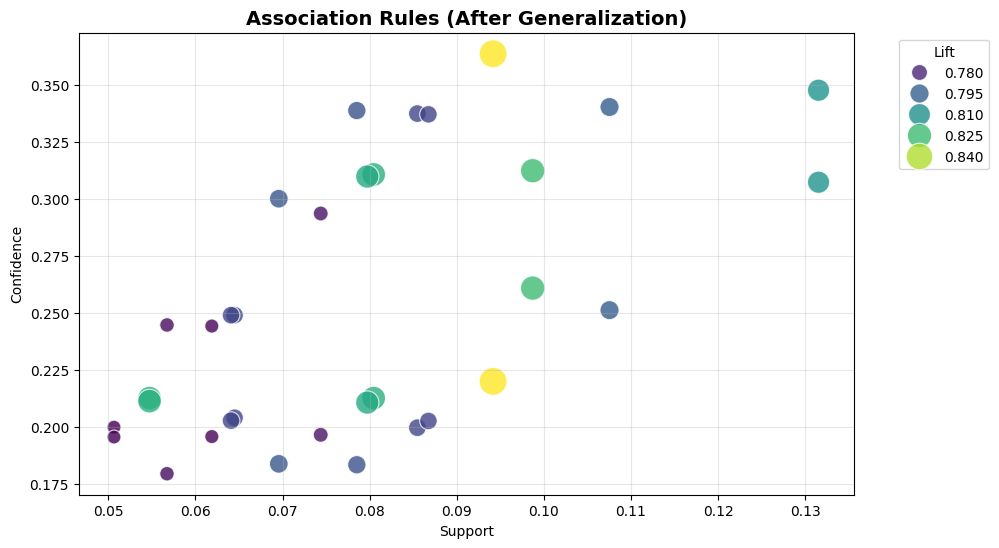

In [33]:
# Run Apriori on Generalized Data
frequent_items_gen, rules_gen = run_apriori(
    df_gen, 
    min_support=0.05, 
    metric="lift", 
    min_threshold=0.5
)

print(f"Found {len(rules_gen)} Strong Rules.")

if not rules_gen.empty:
    print(f"Max Lift Found: {rules_gen['lift'].max():.2f}") 
    print("-" * 50)
    print("Top Actionable Rules (Generalized):")
    rules_gen = rules_gen.sort_values(['lift', 'confidence'], ascending=[False, False])
    print(rules_gen[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_gen, 
        x="support", y="confidence", size="lift", hue="lift", 
        palette="viridis", sizes=(100, 400), alpha=0.8
    )
    plt.title("Association Rules (After Generalization)", fontsize=14, fontweight='bold')
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Lift")
    plt.grid(True, alpha=0.3)
    plt.show()
    
else:
    print("No rules found! Try lower the min_support")

### 🔬 Investigation: Can Generalization Improve Results?

#### 1. Hypothesis & Objective
In the previous phase, we observed high **data sparsity** due to the high granularity of specific items (e.g., distinguishing between different types of fruit). We hypothesized that applying **Generalization** (grouping items into high-level categories like `Dairy`, `Meat`, `Fruit`) would increase the support count and reveal stronger association patterns between major product groups.

#### 2. Experimental Results
Upon running the Apriori algorithm on the generalized dataset, we observed the following:
* **Support Increased:** As expected, the frequency of categories (e.g., Dairy) increased significantly.
* **Lift Decreased:** Surprisingly, the maximum Lift found dropped to **~0.85**.

#### 3. Interpretation & Evaluation
This result provides a critical insight into the customer behavior in this dataset:
* **Negative Correlation:** In association rule mining, a **Lift value < 1** indicates a **negative correlation**. This implies that the presence of one category (e.g., *Meat*) actually **decreases** the likelihood of purchasing another category (e.g., *Dairy*) in the same transaction.
* **Fragmented Shopping Behavior:** The data suggests that customers engage in **targeted shopping trips** (buying specific categories in isolation) rather than comprehensive grocery shopping where all major categories are purchased together. The categories are statistically "repelling" each other rather than attracting.

#### 4. Conclusion & Strategic Decision
Based on this evaluation:
* **Finding:** Generalization diluted the meaningful relationships and revealed that major categories are not strongly bundled.
* **Decision:** We will **revert to the Raw Data Analysis (Specific Items)**. Although the data is sparse, the specific item analysis successfully identified **positive correlations (Lift > 1)**, which are necessary for generating actionable cross-selling recommendations.